<div style="background-color: #ffffff; color: #333; padding: 15px; border: 1px solid #ddd; border-radius: 8px;">
    <a class="anchor" id="1st-bullet"></a>
    <h2 style="color: #795548; font-weight: bold; text-align: center;">Group Project - Data Preprocessing</h2>
    <h3 style="color: #a1887f; text-align: center;">Data Mining 2024/2025</h3>
</div>

<div style="text-align: center;">
    <strong>Group 14</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Francisco Santos</td>
            <td style="border: 1px solid white; padding: 8px;">20240562</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Margarida Raposo</td>
            <td style="border: 1px solid white; padding: 8px;">20241020</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Nuno Nunes</td>
            <td style="border: 1px solid white; padding: 8px;">20240560</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Teresa Menezes</td>
            <td style="border: 1px solid white; padding: 8px;">20240333</td>
        </tr>
    </table>
</div>

### **Structure**
1. [Data Preparation](#add)
2. [Missing Values](#add)
3. [Outliers](#add)
3. Feature Engineering ? https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering

https://medium.com/@revag2014/dbscan-an-easy-clustering-algorithm-and-also-how-to-optimize-it-using-grid-search-69a382b63e85

In [1]:
import pandas as pd
import numpy as np

# Import matplotlib.pyplot and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import os for operating system dependent functionality
import os

# Import ceil from math for ceiling function
from math import ceil

# Import stats from scipy for statistical functions
from scipy import stats

# Import warnings to handle warnings
import warnings

# Import StandardScaler from sklearn.preprocessing for feature scaling
from sklearn.preprocessing import StandardScaler

# Import NearestNeighbors from sklearn.neighbors for nearest neighbors search
from sklearn.neighbors import NearestNeighbors

# Import KneeLocator from kneed to find the "elbow" point in k-distance graph
from kneed import KneeLocator

# Import DBSCAN from sklearn.cluster for DBSCAN clustering
from sklearn.cluster import DBSCAN

# Import silhouette_score from sklearn.metrics to evaluate clustering quality
from sklearn.metrics import silhouette_score

# Import itertools for efficient looping
import itertools

In [19]:
df = pd.read_csv('df1.csv', index_col='customer_id')

## Data Preparation

In [20]:
# exclude customers with no orders
no_orders = df.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) == 0
no_orders = df[no_orders]

In [21]:
# new dataframe with only customers who have ordered
df_customers = df[~df.index.isin(no_orders.index)]

### Missing Values

In [22]:
df_customers = df_customers.replace('-', np.nan)

In [6]:
# get the total number of NaN values for each column
total_nan = df_customers.isna().sum().sort_values(ascending=False)

# get the percentage of NaN values for each column
percent_nan = ((total_nan / len(df_customers)) * 100).round(2)

# create a DataFrame to display the total and percentage of NaN values for each column
nan_stats = pd.DataFrame({'Total NaN': total_nan, 'Percentage NaN': percent_nan})

# no need to display columns with no NaN values
nan_stats = nan_stats[nan_stats['Total NaN'] > 0]

nan_stats

,Total NaN,Percentage NaN
last_promo,16671,52.61
customer_age,727,2.29
age_group,727,2.29
customer_region,442,1.39
first_order,106,0.33


- last_promo has more than half of missing values

- All the other variables have low %, so lets use imputation

- Same % for 'customer_age' and 'age_group' -> NaN values in age_group are probably due to missing values in customer_age

**Last Promo**

In [23]:
# let's substitute missing values with 'no promo'
df_customers['last_promo'].fillna('NO PROMO', inplace=True)

**Customer Age and Age Group**

In [25]:
# Check if missing age_group aligns with missing customer_age
missing_consistency = df_customers[df_customers['customer_age'].isnull()]['age_group'].isnull().all()
print(f"Are all missing age_group values tied to missing customer_age? {missing_consistency}")

Are all missing age_group values tied to missing customer_age? True


Text(0.5, 1.0, 'Distribution of Customer Age')

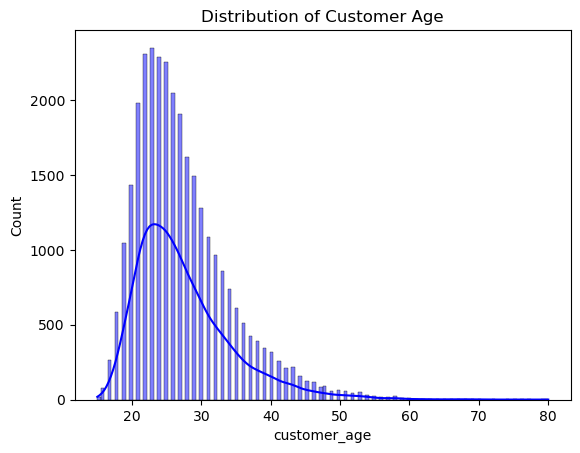

In [26]:
# get distribution of the 'customer_age' column
sns.histplot(df_customers['customer_age'], kde=True, color='blue')
plt.title('Distribution of Customer Age')


- Distribution is right-skewed, let's use the median over the mean

In [27]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill customer_age with the median value
customer_age_median = df_customers['customer_age'].median()  # 26
df_customers['customer_age'].fillna(customer_age_median, inplace=True)

# fill age_group with the respective age group (21-30)
df_customers['age_group'].fillna('21-30', inplace=True)

**Customer Region**

In [31]:
# since we created 'customer_city' we will drop this variable
df_customers.drop(columns='customer_region', inplace=True)

**First_Order** 
- Impute with the mean, median or mode doesn't make sense here. As those missing values represent 0.33% let's drop them

In [32]:
# ignore warnings
warnings.filterwarnings('ignore')

# drop rows where first_order is missing
df_customers.dropna(subset=['first_order'], inplace=True)

## Outliers

In [34]:
# columns which values range from 0 to 1 so they don't need to be scaled
cols_range_0_1 = ['vendor_loyalty_score','relative_cuisine_variety', 'chain_consumption']

# categorical features that represent categorical data
num_cat_features = ['customer_city', 'available_cuisines_city', 'cuisine_variety']

In [35]:
# get metric features
metric_features = df_customers.select_dtypes(include=[np.number]).columns.difference(num_cat_features + cols_range_0_1)
# get non-metric features
non_metric_features = df_customers.select_dtypes(exclude=[np.number]).columns

In [36]:
# scale the metric features for DBSCAN
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_customers[metric_features])

## DBSCAN

**N_Neighbours**

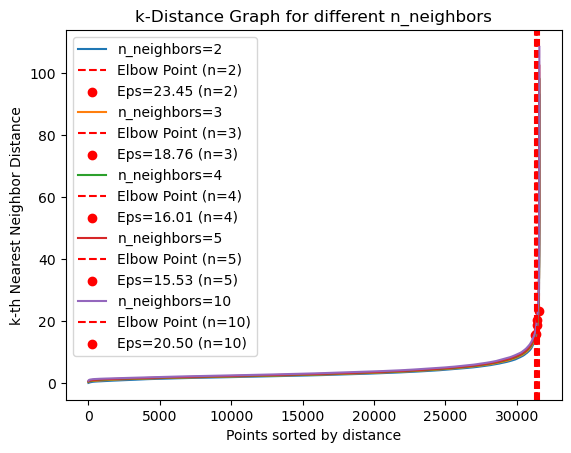

,n_neighbors,Elbow Index,Epsilon
0,2,31523,23.454874
1,3,31434,18.764617
2,4,31323,16.013302
3,5,31281,15.531122
4,10,31422,20.496613


In [37]:
# List of n_neighbors to test
n_neighbors_list = [2, 3, 4, 5, 10]

# Initialize empty lists to store results
elbow_indices = []
epsilons = []

# Perform calculations for each n_neighbors
for n_neighbors in n_neighbors_list:
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data_scaled)
    distances, _ = nbrs.kneighbors(data_scaled)
    distances = np.sort(distances[:, n_neighbors - 1], axis=0)

    # Use KneeLocator to find the elbow point
    kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')

    # Get the elbow point and epsilon
    elbow_index = kneedle.elbow
    epsilon = distances[elbow_index]

    # Store the results
    elbow_indices.append(elbow_index)
    epsilons.append(epsilon)

    # Optional: Highlight the elbow point on the graph for each n_neighbors
    plt.plot(distances, label=f'n_neighbors={n_neighbors}')
    plt.axvline(x=elbow_index, color='r', linestyle='--', label=f'Elbow Point (n={n_neighbors})')
    plt.scatter(elbow_index, epsilon, color='red', label=f'Eps={epsilon:.2f} (n={n_neighbors})')

# Create a DataFrame to store the results
df_results = pd.DataFrame({
    'n_neighbors': n_neighbors_list,
    'Elbow Index': elbow_indices,
    'Epsilon': epsilons
})


# Customize the graph
plt.xlabel('Points sorted by distance')
plt.ylabel('k-th Nearest Neighbor Distance')
plt.title('k-Distance Graph for different n_neighbors')
plt.legend()
plt.show()

# Display the table
df_results


In [38]:
epsilon = np.linspace(15, 25, 20) # range of epsilon values to test based on table above
min_samples = np.arange(2, 12) # range of min_samples values to test based on table above

In [39]:
# get all possible combinations of epsilon and min_samples
combinations = list(itertools.product(epsilon, min_samples))
N = len(combinations)
N

200

In [40]:
# create a function to perform grid search for DBSCAN
def GridSearch(combinations, X):
    scores = []
    all_label = []
    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 2) or (num_clusters > 25):
            scores.append(-20)
            all_label.append("Poor")
            print(" at iteration:", i, "ep =", eps, "min_samples =", num_samples, "number of clusters =", num_clusters, "moving on ..")
            continue
        scores.append(silhouette_score(X, labels))
        all_label.append(labels)
        print(" at iteration:", i, "score:", scores[-1], "Number of clusters:", num_clusters)
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_label[best_index]
    best_score = scores[best_index]
    return {
        'best_epsilon': best_parameters[0],
        'best_min_samples': best_parameters[1],
        'best_labels': best_labels,
        'best_score': best_score
    }

In [41]:
# perform grid search
best_params = GridSearch(combinations, data_scaled)

 at iteration: 0 score: 0.6726640672077049 Number of clusters: 4
 at iteration: 1 ep = 15.0 min_samples = 3 number of clusters = 1 moving on ..
 at iteration: 2 ep = 15.0 min_samples = 4 number of clusters = 1 moving on ..
 at iteration: 3 ep = 15.0 min_samples = 5 number of clusters = 1 moving on ..
 at iteration: 4 ep = 15.0 min_samples = 6 number of clusters = 1 moving on ..
 at iteration: 5 ep = 15.0 min_samples = 7 number of clusters = 1 moving on ..
 at iteration: 6 ep = 15.0 min_samples = 8 number of clusters = 1 moving on ..
 at iteration: 7 ep = 15.0 min_samples = 9 number of clusters = 1 moving on ..
 at iteration: 8 ep = 15.0 min_samples = 10 number of clusters = 1 moving on ..
 at iteration: 9 ep = 15.0 min_samples = 11 number of clusters = 1 moving on ..
 at iteration: 10 score: 0.6847657630407733 Number of clusters: 4
 at iteration: 11 ep = 15.526315789473685 min_samples = 3 number of clusters = 1 moving on ..
 at iteration: 12 ep = 15.526315789473685 min_samples = 4 numb

In [42]:
# display the best parameters
print(best_params)

{'best_epsilon': 21.842105263157894, 'best_min_samples': 2, 'best_labels': array([0, 0, 0, ..., 0, 0, 0]), 'best_score': 0.8049916418618785}


In [43]:
# build the DBSCAN model with the best parameters
dbscan_final = DBSCAN(eps=21.842105263157894, min_samples=2)
clusters = dbscan_final.fit_predict(data_scaled)

In [44]:
# identify and remove outliers
outliers = data_scaled[clusters == -1]  
print(f"Outliers removed: {len(outliers)}")


Outliers removed: 75


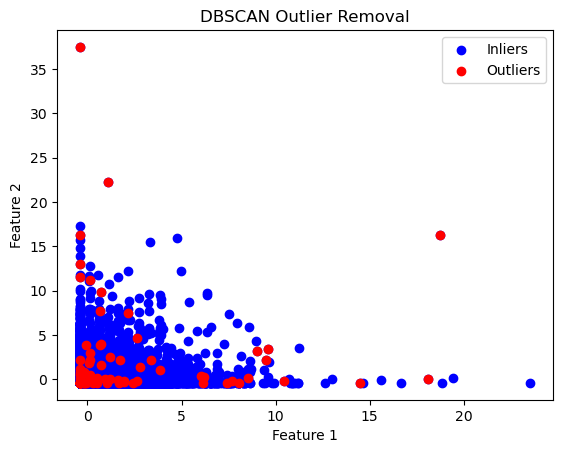

In [45]:
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c='blue', label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
plt.title('DBSCAN Outlier Removal')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

###### transparencia to improve

In [46]:
# calculate the percentage of data that are outliers
outliers_percentage = (len(outliers) / len(data_scaled)) * 100
print(f"Percentage of data identified as outliers: {outliers_percentage:.2f}%")

Percentage of data identified as outliers: 0.24%


In [47]:
df_no_outliers = df_customers[clusters != -1]

In [48]:
df_no_outliers.to_csv('df2.csv', index=True)

In [49]:
df_no_outliers.head()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,...,customer_lifecycle_stage,vendor_loyalty_score,peak_order_day,peak_order_hour,cuisine_variety,available_cuisines_city,relative_cuisine_variety,average_spending,order_frequency,chain_consumption
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.00,0.00,...,Active,0.5,DOW_0,HR_18,1,15,0.066667,14.440,2.0,0.5
5d272b9dcb,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,12.82,6.39,...,Active,0.5,DOW_0,HR_10,2,8,0.250000,9.605,2.0,1.0
f6d1b2ba63,38.0,1,2,2,0.0,1,DISCOUNT,CASH,9.20,0.00,...,Active,1.0,DOW_0,HR_9,1,12,0.083333,4.600,2.0,1.0
180c632ed8,26.0,2,3,1,0.0,2,DELIVERY,DIGI,0.00,13.70,...,Active,0.5,DOW_1,HR_11,2,12,0.166667,15.780,1.0,0.5
4eb37a6705,20.0,2,5,0,0.0,2,NO PROMO,DIGI,14.57,40.87,...,Active,0.5,DOW_1,HR_8,2,12,0.166667,27.720,1.0,0.0
